# Boundary Cell Analysis

This notebook demonstrates how to analyze boundary cells (also called border cells) - neurons that fire preferentially near environmental boundaries. These cells were discovered by Solstad, Boccara, et al. (2008) and are thought to play a role in spatial navigation and path integration.

**What you'll learn:**
1. Generate synthetic border cell firing patterns
2. Compute the border score metric (Solstad et al. 2008)
3. Understand the components of border score calculation
4. Compare border cells vs place cells

**Key concepts:**
- **Border score**: Quantifies how much a cell's firing field hugs environmental boundaries
- **Boundary coverage**: Fraction of boundary bins within the firing field
- **Mean distance**: Average distance from field bins to nearest boundary
- **Score range**: [-1, 1] where high positive values indicate border cells

**Time estimate**: 15-20 minutes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from neurospatial import Environment
from neurospatial.metrics import border_score

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Generate Synthetic Border Cell

We'll create a 2D square arena with clear boundaries and simulate a border cell that fires preferentially along the walls of the environment.

In [2]:
# Generate 2D random walk in square arena (border cells need clear boundaries!)
sampling_rate = 50.0  # Hz
duration = 100.0  # seconds
n_samples = int(duration * sampling_rate)
times = np.linspace(0, duration, n_samples)

# Arena size: 80x80 cm square arena (clear boundaries for border cells)
arena_size = 80.0  # cm
arena_center = arena_size / 2

# Random walk parameters
step_size = 2.0  # cm per step
boundary_margin = 5.0  # cm from walls

# Initialize trajectory
positions = np.zeros((n_samples, 2))
positions[0] = [arena_center, arena_center]  # Start at center

# Generate random walk with wall reflection (explore near boundaries!)
for i in range(1, n_samples):
    # Random step direction
    angle = np.random.uniform(0, 2 * np.pi)
    step = step_size * np.array([np.cos(angle), np.sin(angle)])

    # Propose new position
    new_pos = positions[i - 1] + step

    # Reflect at boundaries (with margin)
    for dim in range(2):
        if new_pos[dim] < boundary_margin:
            new_pos[dim] = boundary_margin + (boundary_margin - new_pos[dim])
        elif new_pos[dim] > (arena_size - boundary_margin):
            new_pos[dim] = (arena_size - boundary_margin) - (
                new_pos[dim] - (arena_size - boundary_margin)
            )

    positions[i] = new_pos

# Create environment with 3cm bins
env = Environment.from_samples(positions, bin_size=3.0)
env.units = "cm"
env.frame = "arena"

print(f"Environment: {arena_size:.0f}x{arena_size:.0f} cm square arena")
print(f"  {env.n_bins} bins, {env.n_dims}D")
print(
    f"  Coverage: x=[{positions[:, 0].min():.1f}, {positions[:, 0].max():.1f}], y=[{positions[:, 1].min():.1f}, {positions[:, 1].max():.1f}] cm"
)
print(f"\nBoundary bins: {len(env.boundary_bins)} (edges of the arena)")

Environment: 80x80 cm square arena
  493 bins, 2D
  Coverage: x=[5.0, 75.0], y=[5.0, 75.0] cm

Boundary bins: 122 (edges of the arena)


### Create Border Cell Firing Pattern

Border cells fire near walls. We'll create a firing rate that:
- Is high near boundaries (distance < 15 cm)
- Decays exponentially with distance from boundary
- Has a peak rate of ~8 Hz near walls

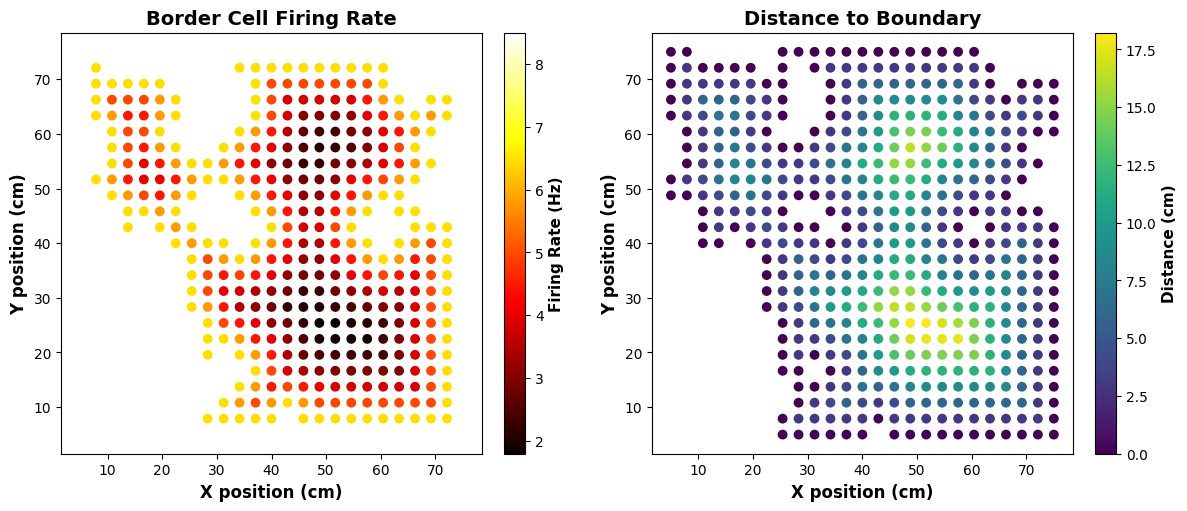

In [3]:
# Compute distance to nearest boundary for each bin
boundary_bins = env.boundary_bins
boundary_distances = env.distance_to(boundary_bins)

# Create border cell firing pattern: high near walls, low in center
# Exponential decay from boundary
scale = 10.0  # cm - decay length scale
peak_rate = 8.0  # Hz
baseline_rate = 0.5  # Hz

border_cell_rate = baseline_rate + peak_rate * np.exp(-boundary_distances / scale)

# Visualize the boundary cell firing pattern
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Left: Firing rate
ax = axes[0]
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=border_cell_rate,
    cmap="hot",
    s=50,
    edgecolors="none",
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title("Border Cell Firing Rate", fontsize=14, fontweight="bold")
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Firing Rate (Hz)", fontsize=11, fontweight="bold")

# Right: Distance to boundary
ax = axes[1]
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=boundary_distances,
    cmap="viridis",
    s=50,
    edgecolors="none",
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title("Distance to Boundary", fontsize=14, fontweight="bold")
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Distance (cm)", fontsize=11, fontweight="bold")

plt.show()

## Part 2: Compute Border Score

The border score (Solstad et al. 2008) quantifies how much a firing field hugs environmental boundaries:

$$\text{border score} = \frac{c_M - d}{c_M + d}$$

where:
- $c_M$ = maximum boundary coverage (fraction of boundary bins in field)
- $d$ = mean distance from field bins to nearest boundary (normalized by environment extent)

**Interpretation:**
- Score > 0.5: Strong border cell
- Score ≈ 0: Neither border nor place cell
- Score < 0: Central field (opposite of border cell)

In [4]:
# Compute border score with default threshold (30% of peak rate)
score = border_score(border_cell_rate, env, threshold=0.3)

print(f"Border Score: {score:.3f}")
print("\nInterpretation:")
if score > 0.5:
    print("  ✓ Strong border cell (score > 0.5)")
elif score > 0.3:
    print("  ~ Moderate border cell (0.3 < score < 0.5)")
elif score > 0:
    print("  ~ Weak border preference (0 < score < 0.3)")
else:
    print("  ✗ Not a border cell (score ≤ 0)")

Border Score: 0.913

Interpretation:
  ✓ Strong border cell (score > 0.5)


### Effect of Threshold Parameter

The threshold parameter determines which bins are considered part of the firing field. Let's see how different thresholds affect the border score:

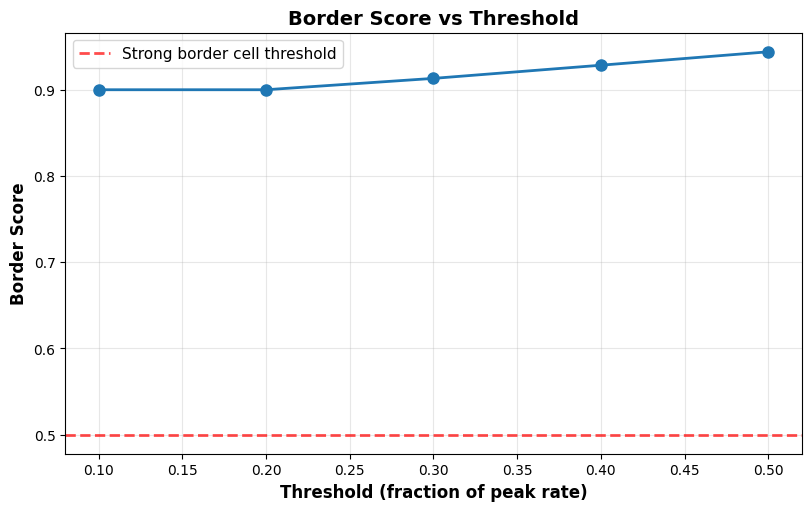

Threshold effects:
  Threshold 0.1: score = 0.900
  Threshold 0.2: score = 0.900
  Threshold 0.3: score = 0.913
  Threshold 0.4: score = 0.928
  Threshold 0.5: score = 0.944


In [5]:
# Test different thresholds
thresholds: list[float] = [0.1, 0.2, 0.3, 0.4, 0.5]
scores: list[float] = [
    border_score(border_cell_rate, env, threshold=t) for t in thresholds
]

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.plot(thresholds, scores, "o-", linewidth=2, markersize=8, color="#1f77b4")
ax.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Strong border cell threshold",
)
ax.set_xlabel("Threshold (fraction of peak rate)", fontsize=12, fontweight="bold")
ax.set_ylabel("Border Score", fontsize=12, fontweight="bold")
ax.set_title("Border Score vs Threshold", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.show()

print("Threshold effects:")
for i in range(len(thresholds)):
    print(f"  Threshold {thresholds[i]:.1f}: score = {scores[i]:.3f}")

## Part 3: Visualize Border Score Components

Let's break down the border score calculation to understand what it's measuring:
1. **Field segmentation** at threshold
2. **Boundary coverage** (which boundary bins are in the field)
3. **Mean distance** from field to boundary

In [6]:
# Segment field at 30% threshold
threshold = 0.3
field_mask = border_cell_rate >= (threshold * border_cell_rate.max())
field_bins = np.where(field_mask)[0]

# Find boundary bins that overlap with field
boundary_mask = np.zeros(env.n_bins, dtype=bool)
boundary_mask[boundary_bins] = True
boundary_in_field = boundary_mask & field_mask

# Compute mean distance from field bins to boundary (using distance_to for all field bins)
field_distances = boundary_distances[field_bins]
mean_distance = field_distances.mean()

# Boundary coverage
boundary_coverage = boundary_in_field.sum() / len(boundary_bins)

# Normalize distance by environment extent
extent_x = env.dimension_ranges[0][1] - env.dimension_ranges[0][0]
extent_y = env.dimension_ranges[1][1] - env.dimension_ranges[1][0]
extent = np.sqrt(extent_x * extent_y)
normalized_distance = mean_distance / extent

print("Border Score Components:")
print(
    f"  Field size: {len(field_bins)} bins ({100 * len(field_bins) / env.n_bins:.1f}% of environment)"
)
print(
    f"  Boundary coverage: {boundary_coverage:.3f} ({100 * boundary_coverage:.1f}% of boundary)"
)
print(f"  Mean distance to boundary: {mean_distance:.1f} cm")
print(f"  Normalized distance: {normalized_distance:.3f}")
print(
    f"  Border score: (c_M - d) / (c_M + d) = ({boundary_coverage:.3f} - {normalized_distance:.3f}) / ({boundary_coverage:.3f} + {normalized_distance:.3f}) = {score:.3f}"
)

Border Score Components:
  Field size: 461 bins (93.5% of environment)
  Boundary coverage: 1.000 (100.0% of boundary)
  Mean distance to boundary: 4.5 cm
  Normalized distance: 0.062
  Border score: (c_M - d) / (c_M + d) = (1.000 - 0.062) / (1.000 + 0.062) = 0.913


### Visualize Components

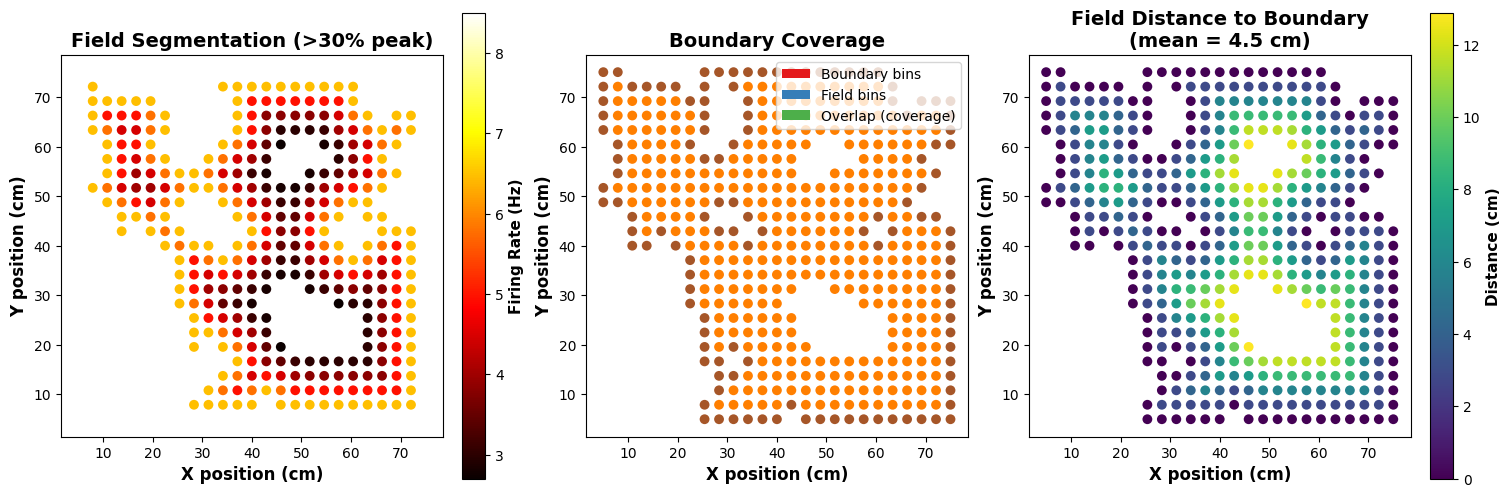

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Panel 1: Field segmentation
ax = axes[0]
colors = np.where(field_mask, border_cell_rate, np.nan)
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=colors,
    cmap="hot",
    s=50,
    edgecolors="none",
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title(
    f"Field Segmentation (>{threshold * 100:.0f}% peak)", fontsize=14, fontweight="bold"
)
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Firing Rate (Hz)", fontsize=11, fontweight="bold")

# Panel 2: Boundary bins
ax = axes[1]
colors = np.full(env.n_bins, np.nan)
colors[boundary_bins] = 1.0  # Boundary bins
colors[field_bins] = 2.0  # Field bins
colors[np.where(boundary_in_field)[0]] = 3.0  # Overlap
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=colors,
    cmap="Set1",
    s=50,
    edgecolors="none",
    vmin=0,
    vmax=4,
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title("Boundary Coverage", fontsize=14, fontweight="bold")
ax.set_aspect("equal")
# Manual legend
legend_elements = [
    Patch(facecolor="#e41a1c", label="Boundary bins"),
    Patch(facecolor="#377eb8", label="Field bins"),
    Patch(facecolor="#4daf4a", label="Overlap (coverage)"),
]
ax.legend(handles=legend_elements, fontsize=10, loc="upper right")

# Panel 3: Distance to boundary
ax = axes[2]
colors = np.full(env.n_bins, np.nan)
colors[field_bins] = field_distances
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=colors,
    cmap="viridis",
    s=50,
    edgecolors="none",
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title(
    f"Field Distance to Boundary\n(mean = {mean_distance:.1f} cm)",
    fontsize=14,
    fontweight="bold",
)
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Distance (cm)", fontsize=11, fontweight="bold")

plt.show()

## Part 4: Compare Border Cell vs Place Cell

To understand what makes a good border cell, let's compare our border cell with a typical place cell (firing in the center of the environment):

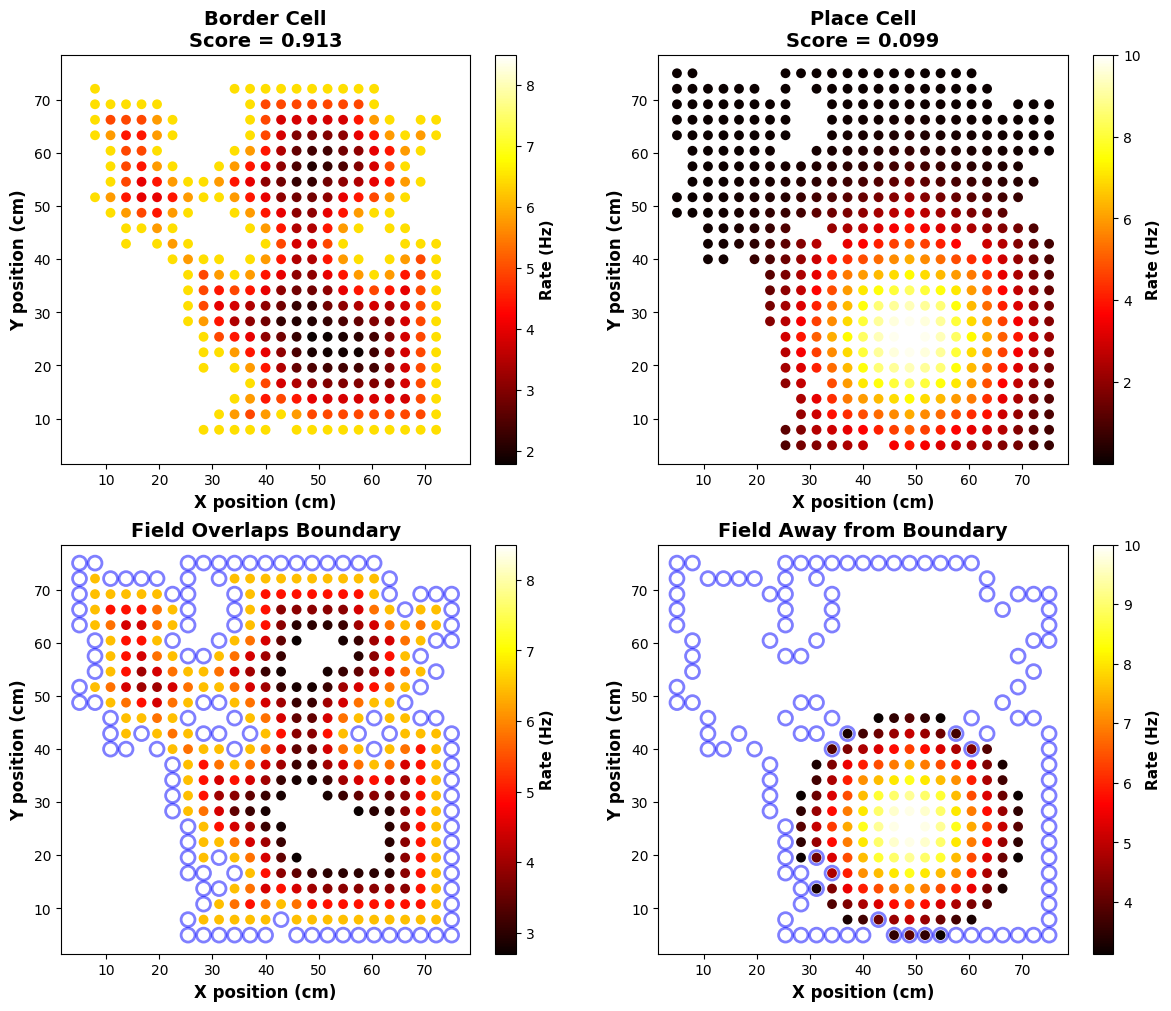

In [8]:
# Create a place cell firing pattern (Gaussian in center)
# Find the most central bin (furthest from boundaries)
center_bin = int(np.argmax(boundary_distances))
distances_from_center = env.distance_to([center_bin])
sigma = 15.0  # cm
place_cell_rate = 10.0 * np.exp(-0.5 * (distances_from_center / sigma) ** 2)

# Compute border scores
border_score_border = border_score(border_cell_rate, env, threshold=0.3)
border_score_place = border_score(place_cell_rate, env, threshold=0.3)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Row 1: Border cell
ax = axes[0, 0]
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=border_cell_rate,
    cmap="hot",
    s=50,
    edgecolors="none",
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title(
    f"Border Cell\nScore = {border_score_border:.3f}", fontsize=14, fontweight="bold"
)
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Rate (Hz)", fontsize=11, fontweight="bold")

# Row 1: Place cell
ax = axes[0, 1]
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=place_cell_rate,
    cmap="hot",
    s=50,
    edgecolors="none",
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title(
    f"Place Cell\nScore = {border_score_place:.3f}", fontsize=14, fontweight="bold"
)
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Rate (Hz)", fontsize=11, fontweight="bold")

# Row 2: Border cell field
ax = axes[1, 0]
field_mask_border = border_cell_rate >= (0.3 * border_cell_rate.max())
colors = np.where(field_mask_border, border_cell_rate, np.nan)
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=colors,
    cmap="hot",
    s=50,
    edgecolors="none",
)
# Highlight boundary bins
boundary_x = env.bin_centers[boundary_bins, 0]
boundary_y = env.bin_centers[boundary_bins, 1]
ax.scatter(
    boundary_x,
    boundary_y,
    s=100,
    facecolors="none",
    edgecolors="blue",
    linewidths=2,
    alpha=0.5,
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title("Field Overlaps Boundary", fontsize=14, fontweight="bold")
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Rate (Hz)", fontsize=11, fontweight="bold")

# Row 2: Place cell field
ax = axes[1, 1]
field_mask_place = place_cell_rate >= (0.3 * place_cell_rate.max())
colors = np.where(field_mask_place, place_cell_rate, np.nan)
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=colors,
    cmap="hot",
    s=50,
    edgecolors="none",
)
# Highlight boundary bins
ax.scatter(
    boundary_x,
    boundary_y,
    s=100,
    facecolors="none",
    edgecolors="blue",
    linewidths=2,
    alpha=0.5,
)
ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
ax.set_title("Field Away from Boundary", fontsize=14, fontweight="bold")
ax.set_aspect("equal")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Rate (Hz)", fontsize=11, fontweight="bold")

plt.show()

### Comparison Summary

In [9]:
print("=" * 60)
print("BORDER CELL vs PLACE CELL COMPARISON")
print("=" * 60)
print("\nBorder Cell:")
print(f"  Border Score: {border_score_border:.3f}")
print(
    f"  Classification: {'✓ Border cell' if border_score_border > 0.5 else '✗ Not border cell'}"
)
print("  Firing pattern: High near walls, low in center")
print("\nPlace Cell:")
print(f"  Border Score: {border_score_place:.3f}")
print(
    f"  Classification: {'✓ Border cell' if border_score_place > 0.5 else '✗ Not border cell'}"
)
print("  Firing pattern: High in center, low near walls")
print(f"\n{'=' * 60}")

BORDER CELL vs PLACE CELL COMPARISON

Border Cell:
  Border Score: 0.913
  Classification: ✓ Border cell
  Firing pattern: High near walls, low in center

Place Cell:
  Border Score: 0.099
  Classification: ✗ Not border cell
  Firing pattern: High in center, low near walls



## Summary

**What we learned:**

1. **Border cells** fire preferentially near environmental boundaries (walls, edges)
2. **Border score** quantifies boundary preference using:
   - Boundary coverage (how much of the boundary is in the field)
   - Mean distance to boundary (how close the field is to walls)
3. **Score interpretation**:
   - > 0.5: Strong border cell (like our synthetic example)
   - 0-0.5: Weak border preference
   - < 0: Central field (place cell)
4. **Threshold matters**: Different thresholds segment the field differently

**Key neuroscience insight:**
Border cells complement place cells in spatial navigation. While place cells encode specific locations, border cells provide a reference frame based on environmental boundaries (Solstad et al., 2008).

**References:**
- Solstad, T., Boccara, C. N., Kropff, E., Moser, M.-B., & Moser, E. I. (2008). Representation of geometric borders in the entorhinal cortex. *Science*, 322(5909), 1865-1868.